# ６章. 学習に関するテクニック

## 6-1. パラメータの更新

最適化問題は難しい。確率的勾配降下法（SGD）は単純で、パラメータ空間を闇雲に探すよりも賢い方法だった。しかし、解決したい問題によってはSDGよりもさらにスマートな手法が存在する。

In [1]:
# -*- coding:utf-8 -*-

# SDG クラスの実装

class SDG:
    
    def __init__(self, lr=0.01):  # lr(learning rate) : 学習係数をインスタンスに持つ
        self.lr = lr
        
    def upgrade(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SDGは関数の形状が等方的でないと、非効率な経路になる。

Momentum

モーメンタムとは運動量を意味し、物理と関係がある。

数式：v←av＊ｎ＊dL/dW, W←W＋v

dL/dW：Wに対する損失関数の勾配

W：更新する重みパラメータ

n：学習係数

v：物理でいうところの速度

av：物体が何も力を受けないときに徐々に減速するための役割を担う，物理でいう地面の摩擦や空気抵抗



In [2]:
# -*- coding:utf-8 -*-

# Momentum の実装

class Momentum:
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

Momentumを使って最適化問題を解くと、SDGよりも早く(0, 0)に向かって収束している様子が確認できる。これはx軸方向に受ける力は小さくても常に同じ方向の力を受けることで加速するためである。y軸方向は正と負の方向の力を交互に受けるため、それらは互いに打ち消し合い、y軸方向の速度が安定しない。これらによってSDGと比較してx軸方向へ早く進み、(0, 0)への収束が早まる。

AdaGrad

学習係数の減衰：学習が進むについて学習係数を小さくすること。最初に大きく学習し、次第に小さく学習するという手法。

AdaGradは一つ一つのパラメータに対して適応的に学習係数を調整しながら学習を行う手法。

数式：h←h＋dL/dW 二乗和 dL/DW,  W←W-n * 1/sqrt(h) * dL/dW

h：これまで経験した勾配の値を２乗和として保持する。パラメータの更新の際にかけ合わせている、1/sqrt(h)を乗算することは学習スケールの調整を担っており、これはパラメータの要素の中で大きく更新された要素は学習係数が次第に小さくなるという学習係数の減衰をパラメータの要素ごとに行うことができる。

In [7]:
# -*- coding;utf-8 -*-

# AdaGrad の実装

import numpy as np

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)  # 1e-7　ゼロ除算を防ぐ

Adam

Momentumは、ボールがお椀を転がるように物理法則に準じる動きを表現し、AdaGradは、パラメータの要素ごとに適応的に更新ステップを調整した。この２つの手法を融合したすることがAdamのベースとなるアイデア。

Adamは2015年に提案された新しい手法であり、理論は複雑だが、先の２つの手法の利点を組み合わせることで効率的にパラメータ空間を探索することが期待される。

Adamは３つのハイパーパラメータを設定する。１．学習係数、２．一次モーメント用の係数b1、３．二次モーメント用の係数b2である。論文によるとb1は0.9, b2は0.999であり、その設定値は多くの場合うまく行くらしい。

MNISTデータセットによる更新手法の比較

５層ニューラルネットワーク、各層１００個のニューロン、活性化関数はReLUを使用したネットワーク。

（ソースコードは配賦済み）

実験は学習係数のハイパーパラメータや、ニューラルネットワークの構造（何層の深さかなど）によって結果は変化する。ただし、一般的にはSDGよりも他の３つの手法が早く学習でき、時には最終的な認識性能も高くなる。

## 6-2. 重みの初期値

ニューラルネットワークで特に重要になってくるのが，重みの初期値です．重みの初期値としてどのような値を設定するかで，ニューラルネットワークの学習の成否が分かれることが実際によくあります．本節では，推奨される重みの初期値について説明し，実験によって実際にニューラルネットワークの学習が速やかに行われることを確認します．

### 重みの初期値を0にする？
これはダメ．これは誤差逆伝播法において，すべての重みの値が均一に更新されてしまうからである．これではたくさんの重みをもつ意味がなくなってしまう．重みの対称的な構造を崩すためには，ランダムな初期値が必要になる．

{0: array([[-0.84236128, -0.615322  , -0.4870198 , ..., -0.68616441,
        -0.42313218, -0.8504631 ],
       [ 0.35663878, -0.37693888, -0.29869558, ...,  0.78043419,
        -0.60249988,  0.33967596],
       [-0.33524879,  0.27064909, -0.58812096, ..., -0.2826891 ,
         0.820206  , -0.78164812],
       ...,
       [-0.81404082,  0.42787376,  0.40552582, ...,  0.80992601,
        -0.46307508, -0.37625091],
       [ 0.17721324,  0.71495973,  0.20539471, ...,  0.16852944,
         0.03279488, -0.87905455],
       [-0.07394374,  0.47169778,  0.85872996, ...,  0.92071571,
        -0.99666681,  0.11056219]]), 1: array([[ 0.73484044,  0.19179053, -0.13099328, ..., -0.12578717,
         0.30119644,  0.32879863],
       [ 0.28342007, -0.10157601,  0.23600676, ...,  0.39986291,
        -0.27118407,  0.32106037],
       [ 0.17639072, -0.44949319, -0.81957904, ...,  0.17025843,
         0.37022795, -0.63106316],
       ...,
       [ 0.28501225,  0.71105885, -0.40189534, ..., -0.1061145 ,
  

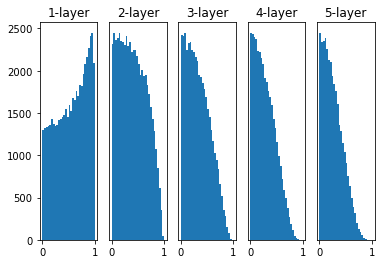

In [14]:
# -*- coding:utf-8 -*-

# 重みの初期値によって隠れ層のアクティベーションがどのように変化するか

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100
hidden_layer_size = 5  # 隠れ層が5層
# ここにアクティベーションの結果を格納する
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
#     w = np.random.randn(node_num, node_num) * 1
#     w = np.random.randn(node_num, node_num) * 0.01

# Xavier の初期値を重みの初期値設定に用いて計算してみる
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    
    
    a = np.dot(x, w)
    
    z = tanh(a)
    activations[i] = z
    
print(activations)
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### 現時点でのベストプラクティス
活性化関数にReLUを使う場合は「Heの初期値」，sigmoidやtanhなどのS字カーブのときは，「Xavierの初期値」を使うこと．

### MNISTデータセットによる重みの初期値の比較
実際のデータを対象に，重みの初期値の与え方の違いによって，ニューラルネットワークの学習にどれだけ影響を与えるか見てみる．

## 6-3. Batch Normalization

前節の重みの初期値では，各層のアクティベーションの分布を観察した．そこで学んだことは，重みの初期値を適切に設定すれば，各層のアクティベーションの分布は適度な広がりを持ち，学習がスムーズに行えるということでした．それでは，各層で適度な広がりを持つように，強制的にアクティベーションの分布を調整してみてはどうでしょうか．実はそのようなアイデアをベースとする手法がBatch Normalizationなのです．

### Batch Normalizationのアルゴリズム
Batch Normalizationは，2015年に提案された手法です．Batch Normは，まだ世に出て間もない新しい手法であるにも関わらず，多くの研究者や技術者に広く使われています．実際，機械学習のコンペティションの結果を見てみると，このBatch Normを使用して，優れた結果を達成している例が多く見られます．

### Batch Normの利点
学習を早く進行させることができる．（学習係数を大きくすることができる）

初期値にそれほど依存しない（初期値に対してそこまで神経質にならなくてよい）

過学習を抑制する（Dropoutなどの必要性を減らす）

## 6-4. 正則化

In [16]:
# -*- coding;utf-8 -*-

import random
import numpy as np

# Dropout

class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    def forward(self, x, train_flg=True):
        if train_flg:
            # xと同じ形状の配列をランダムに生成，drop_ratioより大きい要素がTrue
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    def backward(self, dout):
        return dout * self.mask

## 6-5. ハイパーパラメータの検証

val acc:0.11 | lr:0.0002288822853137688, weight decay:5.9461834590791535e-05
val acc:0.09 | lr:2.869922484109035e-06, weight decay:2.2477590887461148e-05
val acc:0.11 | lr:1.4471106291007841e-05, weight decay:1.1796504292719086e-08
val acc:0.13 | lr:0.0001286945095589172, weight decay:1.559640739601744e-05
val acc:0.34 | lr:0.00216773880454665, weight decay:8.00139467806791e-07
val acc:0.1 | lr:0.00014639462940839256, weight decay:2.674715111645526e-05
val acc:0.09 | lr:8.257268132284985e-06, weight decay:1.7410748787507874e-07
val acc:0.08 | lr:4.7119218121768805e-06, weight decay:2.718185101111719e-07
val acc:0.06 | lr:0.0004418248935823863, weight decay:8.801680499179578e-08
val acc:0.3 | lr:0.0010500888643170106, weight decay:1.5620008500365605e-08
val acc:0.07 | lr:1.0508937658262515e-05, weight decay:2.8160768921427477e-05
val acc:0.09 | lr:0.00018104483187556629, weight decay:1.6705441855841138e-05
val acc:0.06 | lr:5.102216528677106e-05, weight decay:7.618668810877756e-08
val a

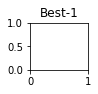

Best-1(val acc:0.63) | lr;0.006832974645371961, weight decay:4.062100245324838e-08


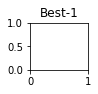

Best-1(val acc:0.63) | lr;0.006798520659260662, weight decay:1.238338472516435e-07


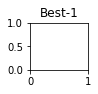

Best-1(val acc:0.63) | lr;0.007001944722823618, weight decay:3.4505045752419034e-05


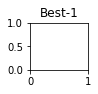

Best-1(val acc:0.63) | lr;0.004691319832361116, weight decay:2.465989504586723e-06


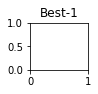

Best-1(val acc:0.63) | lr;0.004221335996760324, weight decay:5.600868376796903e-08


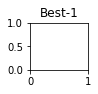

Best-1(val acc:0.63) | lr;0.0055123112077705, weight decay:3.478191718202291e-07


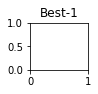

Best-1(val acc:0.63) | lr;0.0049251830068921245, weight decay:1.3508614434940875e-06


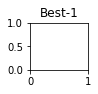

Best-1(val acc:0.63) | lr;0.0015154845706013722, weight decay:5.635601691982477e-06


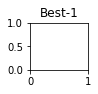

Best-1(val acc:0.63) | lr;0.004211895179990113, weight decay:3.595787524582881e-06


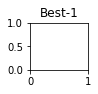

Best-1(val acc:0.63) | lr;0.00216773880454665, weight decay:8.00139467806791e-07


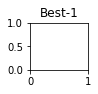

Best-1(val acc:0.63) | lr;0.0031465143092504005, weight decay:7.726451826806206e-06


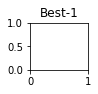

Best-1(val acc:0.63) | lr;0.00125347662402798, weight decay:4.455932526401519e-07


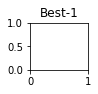

Best-1(val acc:0.63) | lr;0.0026140471201712644, weight decay:7.253998953319493e-05


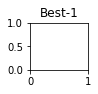

Best-1(val acc:0.63) | lr;0.0009147902251899868, weight decay:1.6341131992520358e-08


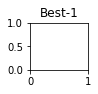

Best-1(val acc:0.63) | lr;0.0010500888643170106, weight decay:1.5620008500365605e-08


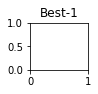

Best-1(val acc:0.63) | lr;0.0015277927247486273, weight decay:2.0165392959065412e-07


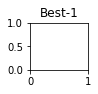

Best-1(val acc:0.63) | lr;0.0015157014288743025, weight decay:1.6695534736686056e-06


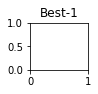

Best-1(val acc:0.63) | lr;0.0010371765241177025, weight decay:2.0044271848793162e-08


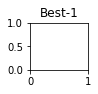

Best-1(val acc:0.63) | lr;0.0005959560893609957, weight decay:6.1245497974519654e-06


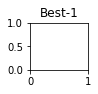

Best-1(val acc:0.63) | lr;0.0005239094227937248, weight decay:1.533774518007488e-08


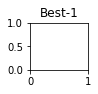

Best-1(val acc:0.63) | lr;0.0011139936491734858, weight decay:2.822731640223011e-07


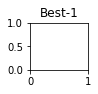

Best-1(val acc:0.63) | lr;0.0001511947805868128, weight decay:1.5115433862892245e-05


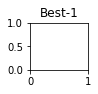

Best-1(val acc:0.63) | lr;2.4717888036142513e-06, weight decay:9.169294716138783e-05


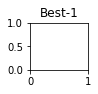

Best-1(val acc:0.63) | lr;7.137048156632981e-05, weight decay:4.03303611607671e-05


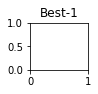

Best-1(val acc:0.63) | lr;0.0011191425586369686, weight decay:1.1894546685498638e-05


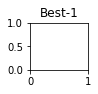

Best-1(val acc:0.63) | lr;0.000299863397287471, weight decay:1.3983708815748564e-08


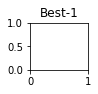

Best-1(val acc:0.63) | lr;0.0009010159711862641, weight decay:4.776427229893823e-07


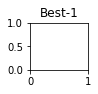

Best-1(val acc:0.63) | lr;0.0006989698411372389, weight decay:3.3229644811963997e-07


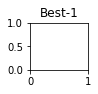

Best-1(val acc:0.63) | lr;4.457402775499244e-06, weight decay:5.561320053333882e-08


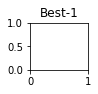

Best-1(val acc:0.63) | lr;1.8618029869226592e-05, weight decay:9.368126780876727e-05


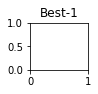

Best-1(val acc:0.63) | lr;1.7931530975389818e-05, weight decay:3.759013688385104e-06


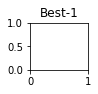

Best-1(val acc:0.63) | lr;3.6406051307954708e-06, weight decay:2.0743100876174412e-08


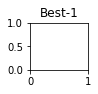

Best-1(val acc:0.63) | lr;0.0001286945095589172, weight decay:1.559640739601744e-05


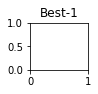

Best-1(val acc:0.63) | lr;3.997458113550237e-06, weight decay:2.2782834215074719e-07


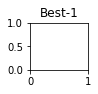

Best-1(val acc:0.63) | lr;1.3463475622135833e-05, weight decay:7.80213780539299e-05


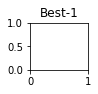

Best-1(val acc:0.63) | lr;1.466788980961543e-05, weight decay:2.068948465088394e-06


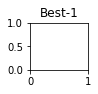

Best-1(val acc:0.63) | lr;0.00016541508130966652, weight decay:6.136307020432777e-05


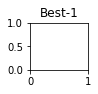

Best-1(val acc:0.63) | lr;9.81191069452863e-06, weight decay:9.621296758268327e-07


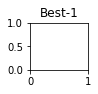

Best-1(val acc:0.63) | lr;3.2469698004423885e-06, weight decay:3.0246658326768803e-08


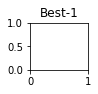

Best-1(val acc:0.63) | lr;5.956709977122175e-05, weight decay:2.8006622381917576e-08


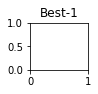

Best-1(val acc:0.63) | lr;1.833471965060205e-05, weight decay:1.6007250335931734e-07


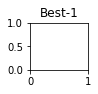

Best-1(val acc:0.63) | lr;0.0009928880867237232, weight decay:1.208322620322642e-07


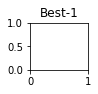

Best-1(val acc:0.63) | lr;2.8144472315705627e-05, weight decay:6.800188223328357e-06


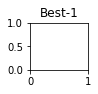

Best-1(val acc:0.63) | lr;0.00010810191350053166, weight decay:2.4130524035331342e-08


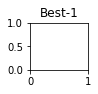

Best-1(val acc:0.63) | lr;0.0002288822853137688, weight decay:5.9461834590791535e-05


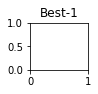

Best-1(val acc:0.63) | lr;1.4471106291007841e-05, weight decay:1.1796504292719086e-08


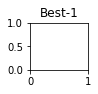

Best-1(val acc:0.63) | lr;8.355481938092544e-06, weight decay:6.539652339973805e-07


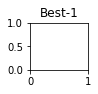

Best-1(val acc:0.63) | lr;1.0985613367006605e-06, weight decay:3.753695773955395e-05


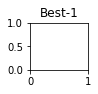

Best-1(val acc:0.63) | lr;1.87466535465683e-05, weight decay:1.524030998986605e-05


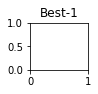

Best-1(val acc:0.63) | lr;1.2222287460765285e-05, weight decay:2.982677538094431e-07


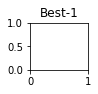

Best-1(val acc:0.63) | lr;3.979367311460702e-05, weight decay:7.933972628438581e-08


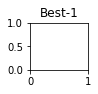

Best-1(val acc:0.63) | lr;3.567584717211145e-06, weight decay:1.0681386091901357e-07


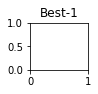

Best-1(val acc:0.63) | lr;3.276671723638542e-05, weight decay:7.562465433185286e-06


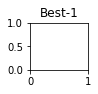

Best-1(val acc:0.63) | lr;9.799026703200342e-06, weight decay:4.763871401067794e-08


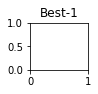

Best-1(val acc:0.63) | lr;9.264962182146529e-06, weight decay:8.54230638455701e-07


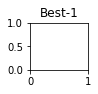

Best-1(val acc:0.63) | lr;0.0006619557350303802, weight decay:7.684789598723107e-05


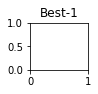

Best-1(val acc:0.63) | lr;0.00014639462940839256, weight decay:2.674715111645526e-05


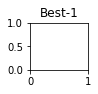

Best-1(val acc:0.63) | lr;6.7280508420545915e-06, weight decay:1.0737177808845085e-05


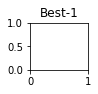

Best-1(val acc:0.63) | lr;0.00010175695046821576, weight decay:1.8471633591224593e-07


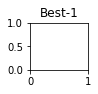

Best-1(val acc:0.63) | lr;1.2846885663829712e-05, weight decay:1.5183195657884078e-05


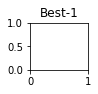

Best-1(val acc:0.63) | lr;3.128335691519894e-05, weight decay:1.0077184397449916e-05


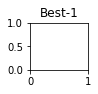

Best-1(val acc:0.63) | lr;4.921421197169801e-05, weight decay:4.4720473710266596e-07


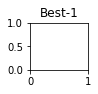

Best-1(val acc:0.63) | lr;0.0003291134963477727, weight decay:1.4178528845769025e-06


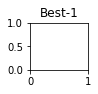

Best-1(val acc:0.63) | lr;2.869922484109035e-06, weight decay:2.2477590887461148e-05


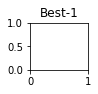

Best-1(val acc:0.63) | lr;8.257268132284985e-06, weight decay:1.7410748787507874e-07


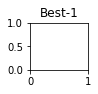

Best-1(val acc:0.63) | lr;0.00018104483187556629, weight decay:1.6705441855841138e-05


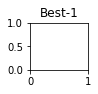

Best-1(val acc:0.63) | lr;8.101902738046888e-06, weight decay:1.0241190224636363e-07


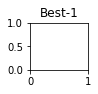

Best-1(val acc:0.63) | lr;1.3441873390995148e-06, weight decay:1.4417562379761772e-08


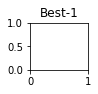

Best-1(val acc:0.63) | lr;2.364424231818566e-05, weight decay:2.3588016915357422e-05


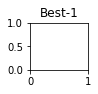

Best-1(val acc:0.63) | lr;3.1692019102198326e-06, weight decay:2.349143329248943e-07


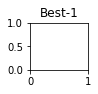

Best-1(val acc:0.63) | lr;1.0923291847982891e-05, weight decay:4.6077438606944444e-06


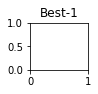

Best-1(val acc:0.63) | lr;4.207984528456675e-06, weight decay:3.3315952272183415e-06


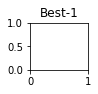

Best-1(val acc:0.63) | lr;4.7119218121768805e-06, weight decay:2.718185101111719e-07


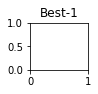

Best-1(val acc:0.63) | lr;1.5800517779054747e-05, weight decay:9.474512197218672e-06


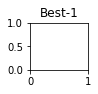

Best-1(val acc:0.63) | lr;0.00018272147721083162, weight decay:8.834860904114513e-05


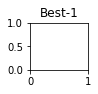

Best-1(val acc:0.63) | lr;7.848172551693596e-06, weight decay:7.560918625822845e-06


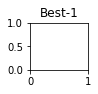

Best-1(val acc:0.63) | lr;0.0005535388041363436, weight decay:7.2914672030261e-06


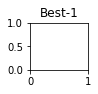

Best-1(val acc:0.63) | lr;3.694260268132565e-06, weight decay:4.113809722546508e-08


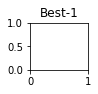

Best-1(val acc:0.63) | lr;0.0007394522639502757, weight decay:1.6937444015566775e-06


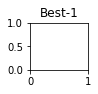

Best-1(val acc:0.63) | lr;1.6985522250606022e-06, weight decay:4.197300394123876e-06


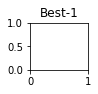

Best-1(val acc:0.63) | lr;6.387409346077554e-05, weight decay:1.518460828344788e-08


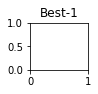

Best-1(val acc:0.63) | lr;1.0508937658262515e-05, weight decay:2.8160768921427477e-05


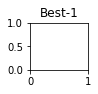

Best-1(val acc:0.63) | lr;1.8611701994327723e-06, weight decay:1.4432387971860915e-05


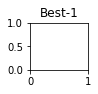

Best-1(val acc:0.63) | lr;1.4804890314927514e-06, weight decay:1.6233102265938294e-07


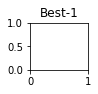

Best-1(val acc:0.63) | lr;2.7983575760963708e-06, weight decay:4.640197617191776e-06


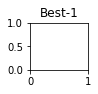

Best-1(val acc:0.63) | lr;7.661418559843827e-05, weight decay:1.4763146497131215e-06


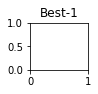

Best-1(val acc:0.63) | lr;8.277384132449665e-06, weight decay:4.911533710987547e-07


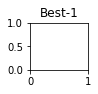

Best-1(val acc:0.63) | lr;1.33724212761718e-06, weight decay:4.911300845175949e-06


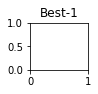

Best-1(val acc:0.63) | lr;7.827447089887106e-05, weight decay:1.258511021968576e-07


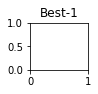

Best-1(val acc:0.63) | lr;7.450505901820274e-05, weight decay:1.8526970055843756e-05


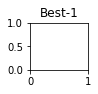

Best-1(val acc:0.63) | lr;0.0004418248935823863, weight decay:8.801680499179578e-08


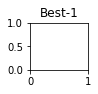

Best-1(val acc:0.63) | lr;5.102216528677106e-05, weight decay:7.618668810877756e-08


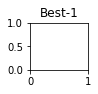

Best-1(val acc:0.63) | lr;3.1381662125179637e-06, weight decay:2.987569620590796e-08


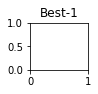

Best-1(val acc:0.63) | lr;1.757599239279598e-06, weight decay:1.1024633522076546e-07


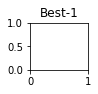

Best-1(val acc:0.63) | lr;1.0920516582726059e-05, weight decay:1.471146319271175e-07


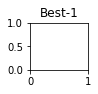

Best-1(val acc:0.63) | lr;0.00031394002395643186, weight decay:1.5288360416196196e-05


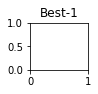

Best-1(val acc:0.63) | lr;5.525614599843141e-05, weight decay:1.5476452934041095e-05


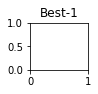

Best-1(val acc:0.63) | lr;2.4069967064635846e-06, weight decay:9.04612408844511e-07


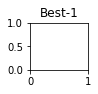

Best-1(val acc:0.63) | lr;1.2507601724475878e-06, weight decay:1.78678232693669e-06


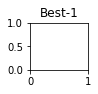

In [22]:
# -*- coding:utf-8 -*-

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のための訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

def __train(lr, weight_decay, epocs=50):
    network=MultiLayerNet(input_size=784, 
                         hidden_size_list=[100, 100, 100, 100, 100, 100],
                         output_size=10,
                         weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                     epochs=epocs, mini_batch_size=100,
                     optimizer='sgd',
                     optimizer_param={'lr':lr}, verbose=False)
    trainer.train()
    
    return trainer.test_acc_list, trainer.train_acc_list

# ハイパーパラメータのランダム探索
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    
    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) \
                           + ", weight decay:" + str(weight_decay))
    key = "lr;" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list
    

print("===============Hyper-Parameter Optimization Result================")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val__acc_list in sorted(results_val.items(), 
                                 key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)
    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
        plt.xticks([])
        x = np.arange(len(val_acc_list))
        plt.plot(x, val_acc_list)
        plt.plot(x, results_train[key], "--")
        i += 1
        
        if i >= graph_draw_num:
            break
    
    plt.show()

    

## 6-6. まとめ